In [81]:
import pandas as pd
import numpy as np
from pathlib import Path

In [82]:
# === 1) Set your file paths here ===
CSV_PATHS = [
    "resources/dataset_project_eHealth20252026.csv",
    "resources/questionnaire_codebook_eHealth20252026.csv",
]
 
# (Optional) If you know the ID column name, set it here; otherwise the code will try to guess.
KNOWN_ID_COL = None  # e.g., "ID" or "RespondentID" or "participant_id"


In [83]:
# === 2) Helper: robust CSV loader (handles common encodings/delimiters) 
def load_csv_robust(path: str) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    # Try default; if it fails, try common alternatives
    trials = [
        dict(encoding=None, sep=None, engine="python"),          # auto-detect sep
        dict(encoding="utf-8", sep=None, engine="python"),
        dict(encoding="latin-1", sep=None, engine="python"),
        dict(encoding=None, sep=",", engine="python"),
        dict(encoding=None, sep=";", engine="python"),
    ]
    last_err = None
    for kw in trials:
        try:
            return pd.read_csv(path, **kw)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not read {path} – last error:\n{last_err}")
 

In [84]:
# === 3) Load both CSVs and show basic info ===
for p in CSV_PATHS:
    df = load_csv_robust(p)
    print(f"\n=== Loaded: {p} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print("First 20 column names:", list(df.columns[:20]))
    print("\nDtypes:")
    print(df.dtypes.head(15))


=== Loaded: resources/dataset_project_eHealth20252026.csv ===
Shape: 221 rows × 96 cols
First 20 column names: ['age', 'gender', 'education', 'marital', 'income', 'audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10', 'dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5']

Dtypes:
age          float64
gender         int64
education    float64
marital      float64
income         int64
audit_1        int64
audit_2        int64
audit_3      float64
audit_4        int64
audit_5      float64
audit_6        int64
audit_7      float64
audit_8      float64
audit_9      float64
audit_10     float64
dtype: object

=== Loaded: resources/questionnaire_codebook_eHealth20252026.csv ===
Shape: 96 rows × 4 cols
First 20 column names: ['\ufeffquestion', 'type', 'name of column', '[codification] options (if applicable)']

Dtypes:
﻿question                                 object
type                                      object
name of column            

We need to do some cleaning in dataset csv 
For the Nan values, replace NaN with the mean values of that question

Each prefix is the abbreviation for a different questionnaire or scale:

audit: Alcohol Use Disorders Identification Test

dast: Drug Abuse Screening Test

pgsi: Problem Gambling Severity Index

iat: Internet Addiction Test

pcl5: PTSD Checklist for DSM-5

mspss: Multidimensional Scale of Perceived Social Support

swls: Satisfaction With Life Scale

who5: WHO-5 Well-Being Index

In [85]:
questionnaires = [
    "audit",
    "dast",
    "pgsi",
    "iat",
    "pcl5",
    "mspss",
    "swls",
    "who5"
]

In [86]:
#Clean data

dataset = load_csv_robust(CSV_PATHS[0])
nan_rows_df1 = dataset.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")

# Suppose your DataFrame is called dataset
flag_nan_or_empty = dataset.isna() | (dataset == "")
nan_or_empty_rows = dataset.index[flag_nan_or_empty.any(axis=1)].tolist()

print(f"Rows with NaN or empty string values: {nan_or_empty_rows}")

NaN rows in df1: 67
Rows with NaN or empty string values: [2, 6, 8, 13, 17, 18, 28, 29, 31, 35, 37, 39, 49, 53, 57, 59, 61, 62, 64, 66, 68, 69, 74, 79, 82, 83, 88, 91, 92, 95, 96, 100, 105, 107, 109, 110, 111, 114, 115, 116, 117, 120, 122, 129, 132, 133, 140, 141, 142, 149, 151, 156, 157, 162, 165, 170, 173, 181, 183, 195, 199, 201, 204, 206, 214, 215, 219]


In [87]:
df_filled = dataset.copy()

# Get only the questionnaire columns (skipping demographic first 5)
questionnaire_cols = dataset.columns[5:]

for q in questionnaires:
    q_cols = [col for col in questionnaire_cols if col.startswith(q + "_")]
    dataset[q_cols] = dataset[q_cols].replace("", np.nan)
    dataset[q_cols] = dataset[q_cols].apply(pd.to_numeric, errors='coerce')
    for idx, row in dataset.iterrows():
        med = row[q_cols].median(skipna=True)
        df_filled.loc[idx, q_cols] = row[q_cols].fillna(med)

# Save the filled dataset locally with a new name
df_filled.to_csv('filled_personal_medians.csv', index=False)

In [88]:
#Clean data

nan_rows_df1 = df_filled.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")


NaN rows in df1: 3


Filling numerical Nan values age and income with median and categorical with mode

In [89]:
# Učitaj postojeći fajl
df = pd.read_csv("filled_personal_medians.csv")

cols_to_fill = ["age", "gender", "education", "marital", "income"]

print("NaN BEFORE filling:\n", df[cols_to_fill].isna().sum(), "\n")

for col in cols_to_fill:
    if col not in df.columns:
        print(f"⚠️ Column '{col}' not found, skipping.")
        continue

    # Ako je numerička kolona → popuni medianom
    if pd.api.types.is_numeric_dtype(df[col]):
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)
        print(f"✅ {col}: filled NaN with median = {med}")

    else:
        # Ako je kategorijska → popuni modom (najčešćom vrednošću)
        s = df[col].astype("string").str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        mode_vals = s.mode(dropna=True)
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df[col] = s.fillna(mode_val)
            print(f"✅ {col}: filled NaN with mode = '{mode_val}'")
        else:
            df[col] = s.fillna("Unknown")
            print(f"ℹ️ {col}: all values were NaN → filled with 'Unknown'")

print("\nNaN AFTER filling:\n", df[cols_to_fill].isna().sum())

# 💾 Prepiši originalni fajl (overwrite)
df.to_csv("filled_personal_medians.csv", index=False)
print("\n✅ Updated 'filled_personal_medians.csv' saved — all NaN values replaced.")


NaN BEFORE filling:
 age          1
gender       0
education    1
marital      1
income       0
dtype: int64 

✅ age: filled NaN with median = 29.0
✅ gender: filled NaN with median = 1.0
✅ education: filled NaN with median = 13.0
✅ marital: filled NaN with median = 1.0
✅ income: filled NaN with median = 25000.0

NaN AFTER filling:
 age          0
gender       0
education    0
marital      0
income       0
dtype: int64

✅ Updated 'filled_personal_medians.csv' saved — all NaN values replaced.


making the question dast_3 reversed in answers - if someone answered Yes we put to No and vice versa

In [90]:
# Reverse the values in the 'dast_3' column: 0 → 1 and 1 → 0
if "dast_3" in df.columns:
    df["dast_3"] = df["dast_3"].replace({0: 1, 1: 0})
    print("Reversed values for 'dast_3'.")
else:
    print("Column 'dast_3' not found.")

Reversed values for 'dast_3'.


Searching for the outliers at first 5 columns

In [91]:
personal_cols = ["age", "gender", "education", "marital", "income"]

print("\n=== Basic stats for first 5 personal columns ===")
for col in personal_cols:
    if col not in df.columns:
        print(f"⚠️ Column '{col}' not found in dataset — skipping.")
        continue
    
    # ako je numerička kolona → prikaz min i max
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min(skipna=True)
        col_max = df[col].max(skipna=True)
        print(f"{col}: min = {col_min}, max = {col_max}")
    else:
        # ako je kategorijska kolona → prikaži broj unikatnih i top 3 vrednosti
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)} unique values → {df[col].value_counts().head(3).to_dict()}")


=== Basic stats for first 5 personal columns ===
age: min = 18.0, max = 40.0
gender: min = 0, max = 3
education: min = 5.0, max = 25.0
marital: min = 0.0, max = 5.0
income: min = 10000, max = 96600


Searching for the outliers in the other columns

In [92]:
from scipy import stats
# ✅ Assuming df is already loaded and first 5 columns are personal info
excluded_cols = ["age", "gender", "education", "marital", "income"]

# Select only numeric questionnaire columns (excluding first 5)
questionnaire_cols = [
    c for c in df.columns
    if c not in excluded_cols and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Number of questionnaire columns: {len(questionnaire_cols)}")

# Compute z-scores for those columns
z_scores = np.abs(stats.zscore(df[questionnaire_cols], nan_policy='omit'))

# Create a boolean mask of outliers (|z| > 3)
outlier_mask = (z_scores > 3)

# Count outliers per column
outlier_counts = pd.DataFrame({
    "num_outliers": outlier_mask.sum(axis=0).astype(int),
    "percent_outliers": (outlier_mask.sum(axis=0) / len(df) * 100).round(2)
})

print("\n=== Outlier Summary (|z| > 3) ===")
display(outlier_counts.sort_values("num_outliers", ascending=False).head(20))

# Optional: mark rows that have at least one outlier
df["has_outlier"] = outlier_mask.any(axis=1)

print(f"\nRows with at least one outlier: {df['has_outlier'].sum()} of {len(df)} total")

# Optional: Save summary
# outlier_counts.to_csv("outlier_summary_questionnaires.csv")

Number of questionnaire columns: 91

=== Outlier Summary (|z| > 3) ===


,num_outliers,percent_outliers
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0



Rows with at least one outlier: 0 of 221 total


we are reversing the numeric scale of who, swls and mspss for it to be consistant with other questions

In [93]:
def reverse_scale(series):
    """Return a reversed version of a numeric series."""
    return (series.max() - series) + series.min()

for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
    if col in df.columns:
        df[col + "_reversed"] = reverse_scale(df[col])
        print(f"Created reversed version of {col}")

Summing the values of all questions to the total for each problem

In [94]:
# 1) Load the file you want to modify
df = pd.read_csv("filled_personal_medians.csv")

# 2) Define a safe selector: only questions like AUDIT_1, AUDIT_2, ...
def compute_total(prefix):
    cols = [c for c in df.columns if c.upper().startswith(prefix + "_")]
    print(f"{prefix}: found {len(cols)} item columns ->", cols[:10], "..." if len(cols) > 10 else "")
    if cols:
        # convert to numeric just in case
        df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)
        print(f"{prefix}_total added.")
    else:
        print(f"No columns found for {prefix} (check column names).")

# 3) Compute totals for all instruments you have
for prefix in ["AUDIT", "DAST", "IAT", "PGSI", "PCL5", "MSPSS", "SWLS", "WHO5"]:
    compute_total(prefix)

# 4) Quick verification in-memory
print(df[[c for c in df.columns if c.endswith("_total")]].head())

# 5) Save back OVER the same CSV
df.to_csv("filled_personal_medians.csv", index=False)

# 6) Optional: re-load to confirm it persisted
check = pd.read_csv("filled_personal_medians.csv")
print("Totals present after reload:", [c for c in check.columns if c.endswith("_total")])

AUDIT: found 10 item columns -> ['audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10'] 
AUDIT_total added.
DAST: found 10 item columns -> ['dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5', 'dast_6', 'dast_7', 'dast_8', 'dast_9', 'dast_10'] 
DAST_total added.
IAT: found 20 item columns -> ['iat_1', 'iat_2', 'iat_3', 'iat_4', 'iat_5', 'iat_6', 'iat_7', 'iat_8', 'iat_9', 'iat_10'] ...
IAT_total added.
PGSI: found 9 item columns -> ['pgsi_1', 'pgsi_2', 'pgsi_3', 'pgsi_4', 'pgsi_5', 'pgsi_6', 'pgsi_7', 'pgsi_8', 'pgsi_9'] 
PGSI_total added.
PCL5: found 20 item columns -> ['pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7', 'pcl5_8', 'pcl5_9', 'pcl5_10'] ...
PCL5_total added.
MSPSS: found 12 item columns -> ['mspss_1', 'mspss_2', 'mspss_3', 'mspss_4', 'mspss_5', 'mspss_6', 'mspss_7', 'mspss_8', 'mspss_9', 'mspss_10'] ...
MSPSS_total added.
SWLS: found 5 item columns -> ['swls_1', 'swls_2', 'swls_3', 'swls_4', 'swls_5'

C:\Users\Visnja\AppData\Local\Temp\ipykernel_14888\3313532568.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)


making a new db just with total values and first 5 columns

In [95]:
# Select the personal columns (first 5)
personal_cols = ["age", "gender", "education", "marital", "income"]

# Select all total score columns (those ending with "_total")
total_cols = [c for c in df.columns if c.endswith("_total")]

# Combine them
columns_to_keep = personal_cols + total_cols

# Create a new DataFrame
df_totals = df[columns_to_keep].copy()

# Quick check
print(df_totals.head())

# Save to a new CSV file
output_name = "totals_with_personal_info.csv"
df_totals.to_csv(output_name, index=False)
print(f"Saved new dataset: {output_name}")

    age  gender  education  marital  income  AUDIT_total  DAST_total  \
0  39.0       0        8.0      1.0   14000         25.0         0.0   
1  18.0       1        5.0      1.0   25000         16.0         0.0   
2  40.0       0       13.0      2.0   56000          0.0         8.0   
3  24.0       1       22.0      0.0   35000          7.0         8.0   
4  19.0       1       22.0      1.0   42000         14.0         4.0   

   IAT_total  PGSI_total  PCL5_total  MSPSS_total  SWLS_total  WHO5_total  
0       39.0        24.0         0.0         51.0         8.0        13.0  
1       33.0         8.0         6.0         43.0        14.0         7.0  
2       60.0         0.0        50.0         18.0         8.0        13.0  
3       56.0         0.0        63.0         26.0        15.0        11.0  
4        0.0         1.0         8.0         61.0        27.0        20.0  
Saved new dataset: totals_with_personal_info.csv


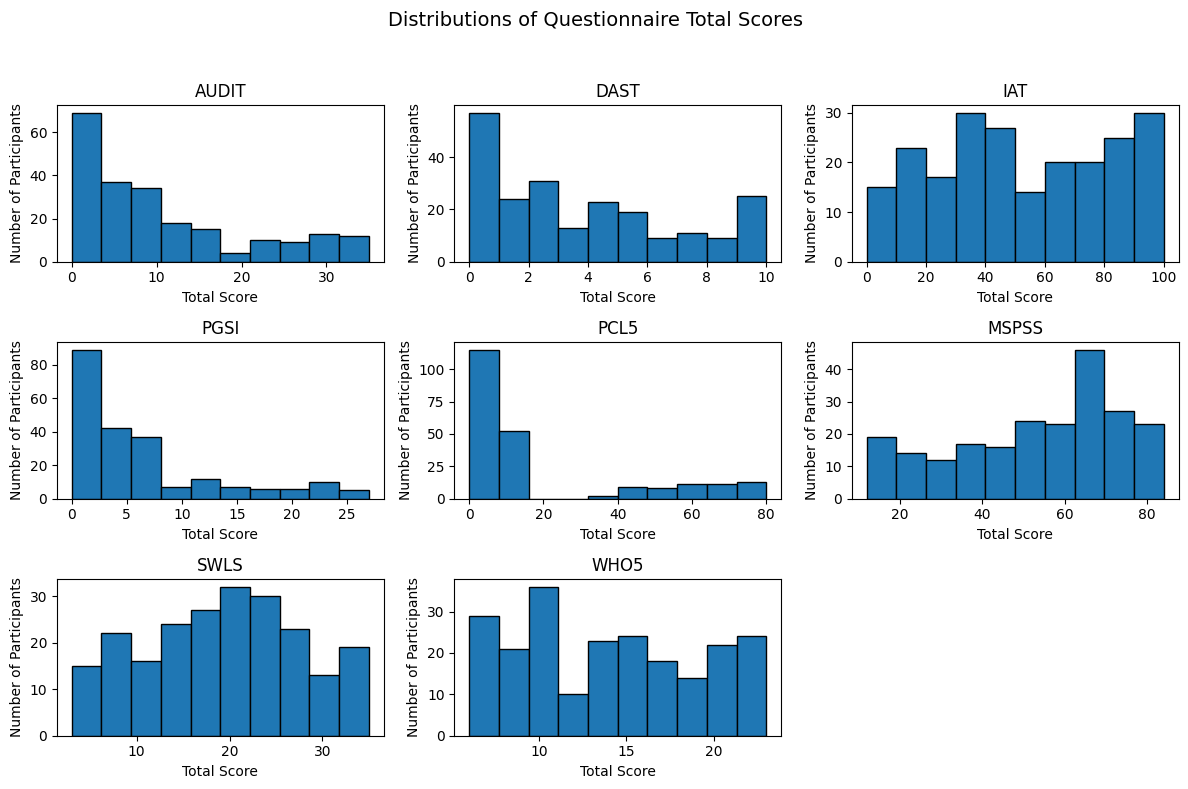

In [96]:
import matplotlib.pyplot as plt

# All columns that end with "_total"
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Create histograms for each total score
axes = df_totals[totals].hist(
    bins=10,
    figsize=(12, 8),
    edgecolor='black',
    grid=False
)

# Add common labels
for ax in axes.flatten():
    ax.set_xlabel("Total Score")          # x-axis
    ax.set_ylabel("Number of Participants")  # y-axis
    ax.set_title(ax.get_title().replace("_total", "").upper())

plt.suptitle("Distributions of Questionnaire Total Scores", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

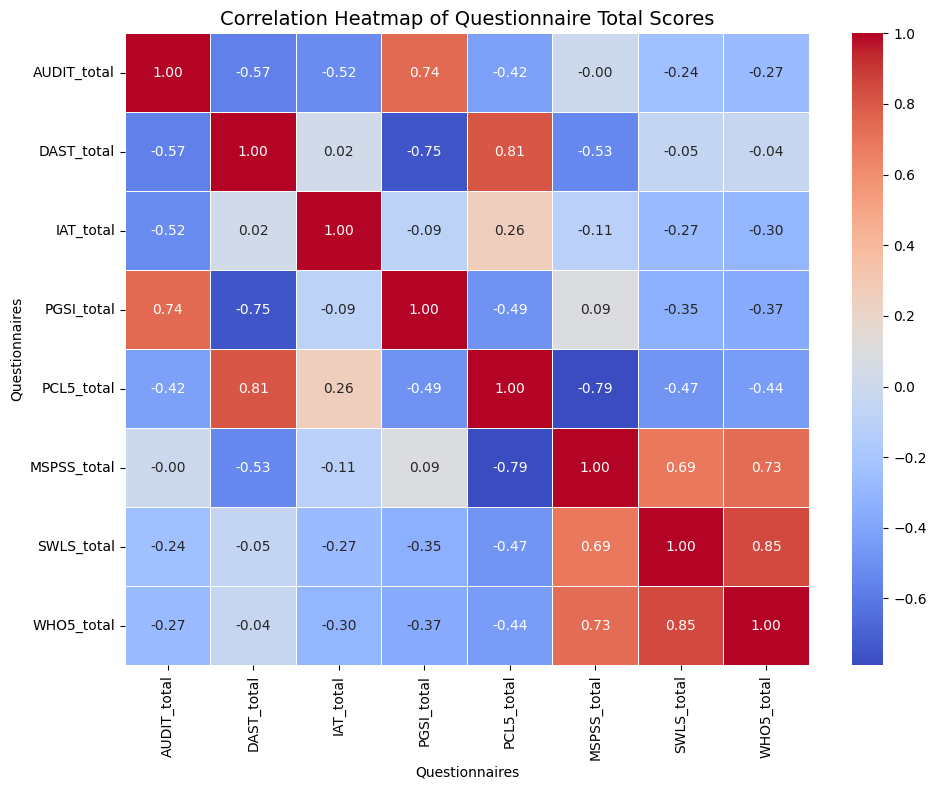

In [97]:
import seaborn as sns


# Select only the total score columns
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Compute the correlation matrix
corr = df_totals[totals].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,           # show the correlation values
    cmap="coolwarm",      # color palette (blue = negative, red = positive)
    fmt=".2f",            # format numbers to 2 decimals
    linewidths=0.5
)

plt.title("Correlation Heatmap of Questionnaire Total Scores", fontsize=14)
plt.xlabel("Questionnaires")
plt.ylabel("Questionnaires")
plt.tight_layout()
plt.show()

Co-occurrence of addictions: Alcohol and gambling problems tend to appear together (shared behavioral tendencies).

Different addiction profiles: Drug use (DAST) behaves differently from alcohol/gambling, possibly indicating a separate risk group.

Mental-health context: PTSD symptoms (PCL5) correlate positively with substance-use problems and negatively with social support and well-being.

Protective factors: High social support (MSPSS) and life satisfaction (SWLS/WHO5) move together and counterbalance addiction and trauma scores.

making the heatmap which includes also age, gender, marital status, education, income

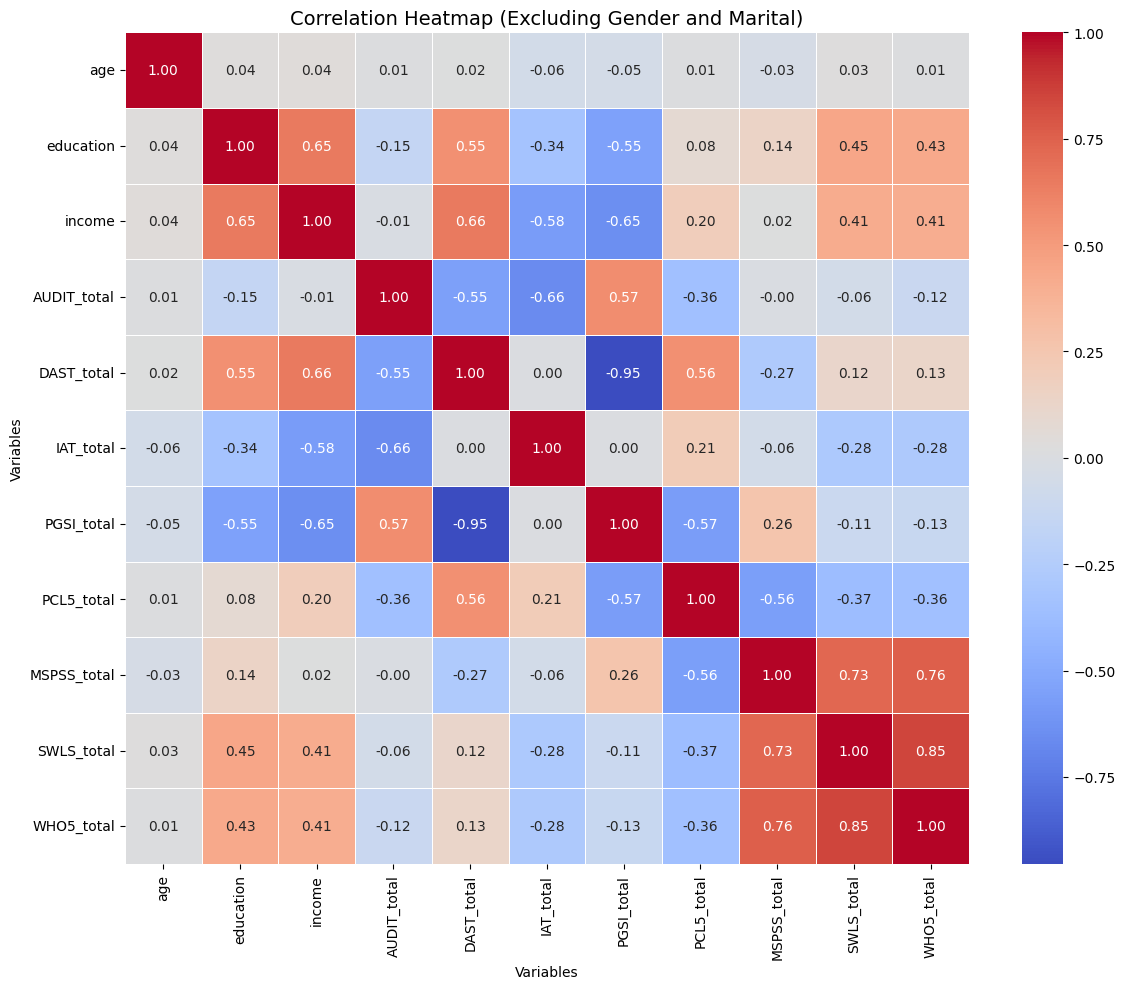

In [98]:
# Make a copy of your df_totals
df_numeric = df_totals.drop(columns=["gender", "marital"], errors="ignore")

# Keep only numeric columns
df_numeric = df_numeric.select_dtypes(include=["number"])

# Compute the correlation matrix (Spearman is best for ordinal/numeric mixes)
corr = df_numeric.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Excluding Gender and Marital)", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()



 The following thresholds are based on the official scoring manuals for each questionnaire. 
 Higher total scores on AUDIT, DAST, IAT, PGSI, and PCL-5 indicate greater severity of addiction 
 or psychological distress, while higher totals on MSPSS, SWLS, and WHO-5 indicate stronger social 
 support and well-being (protective factors). Because these scales are oriented in opposite directions, 
the well-being measures can be reverse-coded when needed so that higher values consistently represent 
 worse outcomes across all questionnaires. This ensures that correlation and clustering analyses are 
conceptually consistent and easier to interpret.

Creating the severity of the problem based on total values

In [99]:
# 1) Reverse-code helper (keeps the original column; writes *_rev)
def reverse_scale(s: pd.Series) -> pd.Series:
    # Handles NaNs; preserves original min/max range
    return (s.max(skipna=True) - s) + s.min(skipna=True)

# 2) Create reversed totals for well-being scales (higher = worse on *_rev)
for col in ["MSPSS_total", "SWLS_total", "WHO5_total"]:
    if col in df.columns:
        df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))

# 3) Severity/risk categorization functions (standard cutoffs)

def cat_audit(x):
    if pd.isna(x): return np.nan
    if x <= 7:   return "low"
    if x <= 15:  return "medium"
    if x <= 19:  return "high"
    return "possible_dependence"

def cat_dast(x):
    if pd.isna(x): return np.nan
    if x == 0:    return "no_problem"
    if x <= 2:    return "low"
    if x <= 5:    return "moderate"
    if x <= 8:    return "substantial"
    return "severe"

def cat_iat(x):
    if pd.isna(x): return np.nan
    if x <= 39:    return "normal"
    if x <= 69:    return "problematic"
    return "severe"

def cat_pgsi(x):
    if pd.isna(x): return np.nan
    if x == 0:     return "non_problem"
    if x <= 2:     return "low_risk"
    if x <= 7:     return "moderate"
    return "problem_gambler"

def cat_pcl5(x):
    if pd.isna(x): return np.nan
    if x <= 19:    return "very_low"
    if x <= 33:    return "possible_ptsd"
    if x <= 49:    return "probable_ptsd"
    return "severe_ptsd"

# For well-being/support, labels on the REVERSED versions (higher = worse)
def cat_mspss(x):
    if pd.isna(x): return np.nan
    if x <= 35:    return "high_support"        # previously low
    if x <= 60:    return "moderate_support"
    return "low_support"                        # previously high

def cat_swls(x):
    if pd.isna(x): return np.nan
    if x <= 9:     return "extremely_satisfied"       # previously dissatisfied
    if x <= 14:    return "satisfied"
    if x <= 19:    return "slightly_above_avg"
    if x == 20:    return "neutral"
    if x <= 25:    return "slightly_dissatisfied"
    if x <= 30:    return "dissatisfied"
    return "extremely_dissatisfied"                  # previously extremely satisfied

def cat_who5(x):
    if pd.isna(x): return np.nan
    return "good_wellbeing" if x < 13 else "poor_wellbeing"

# 4) Apply labels (only if the total exists)
label_map = {
    "AUDIT_total": ("AUDIT_label", cat_audit),
    "DAST_total":  ("DAST_label",  cat_dast),
    "IAT_total":   ("IAT_label",   cat_iat),
    "PGSI_total":  ("PGSI_label",  cat_pgsi),
    "PCL5_total":  ("PCL5_label",  cat_pcl5),
    "MSPSS_total": ("MSPSS_label", cat_mspss),
    "SWLS_total":  ("SWLS_label",  cat_swls),
    "WHO5_total":  ("WHO5_label",  cat_who5),
}

for total_col, (label_col, func) in label_map.items():
    if total_col in df.columns:
        df[label_col] = pd.to_numeric(df[total_col], errors="coerce").apply(func)

# 5) (Optional) Build a compact export with personals, totals, reversed totals, and labels
personal_cols = [c for c in ["age","gender","education","marital","income"] if c in df.columns]
total_cols    = [c for c in df.columns if c.endswith("_total")]
rev_cols      = [c for c in df.columns if c.endswith("_total_rev")]
label_cols    = [c for c in df.columns if c.endswith("_label")]

export_cols   = personal_cols + total_cols + rev_cols + label_cols
df_export = df[export_cols].copy()

# Save
df_export.to_csv("totals_labels_reversed.csv", index=False)
print("Saved: totals_labels_reversed.csv")

Saved: totals_labels_reversed.csv


C:\Users\Visnja\AppData\Local\Temp\ipykernel_14888\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))
C:\Users\Visnja\AppData\Local\Temp\ipykernel_14888\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_rev"] = reverse_scale(pd.to_numeric(df[col], errors="coerce"))
C:\Users\Visnja\AppData\Local\Temp\ipykernel_14888\3271019992.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

NORMALIZED VALUES - to compare the problems

In [100]:
# Example assumes you used StandardScaler
from sklearn.preprocessing import StandardScaler
import pandas as pd

totals = [c for c in df.columns if c.endswith("_total")]

# Normalize totals
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df[totals]), columns=[f"{c}_z" for c in totals])

# Combine normalized totals with the original personal info
personal_cols = ["age", "gender", "education", "marital", "income"]
personal_cols = [c for c in personal_cols if c in df.columns]  # keep only those that exist
df_normalized = pd.concat([df[personal_cols], X_scaled], axis=1)

# Save to CSV
df_normalized.to_csv("normalized_totals.csv", index=False)
print("Saved normalized totals to 'normalized_totals.csv'")

Saved normalized totals to 'normalized_totals.csv'


PCA

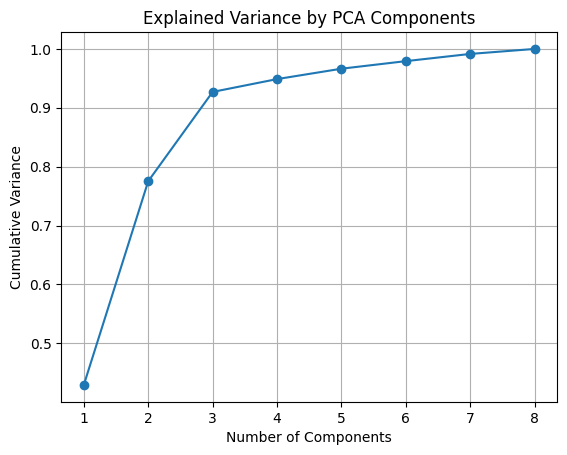

                  PC1       PC2       PC3       PC4       PC5       PC6  \
AUDIT_total -0.235310  0.456467 -0.372974  0.131794 -0.289268  0.669249   
DAST_total   0.411898 -0.298867 -0.301707 -0.018820  0.319187  0.133835   
IAT_total    0.212220 -0.013895  0.820317  0.180630 -0.019399  0.409271   
PGSI_total  -0.234456  0.503516  0.104045 -0.015927  0.823335 -0.005521   
PCL5_total   0.514696 -0.057525 -0.126242 -0.149114  0.192591  0.476874   
MSPSS_total -0.459680 -0.217372  0.230776 -0.411919 -0.074755  0.227798   
SWLS_total  -0.316425 -0.438699 -0.086249  0.769627  0.198888  0.143313   
WHO5_total  -0.314037 -0.453406 -0.097386 -0.406396  0.232276  0.258498   

                  PC7       PC8  
AUDIT_total  0.019448 -0.218721  
DAST_total   0.496602 -0.532195  
IAT_total   -0.072579 -0.275819  
PGSI_total   0.047969  0.014529  
PCL5_total  -0.102878  0.646933  
MSPSS_total  0.630840  0.251135  
SWLS_total   0.038739  0.214612  
WHO5_total  -0.579133 -0.254937  


In [109]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pandas as pd
 
pca = PCA()

X_pca = pca.fit_transform(X_scaled)
 
# Cumulative variance plot

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 

         pca.explained_variance_ratio_.cumsum(), marker='o')

plt.title("Explained Variance by PCA Components")

plt.xlabel("Number of Components")

plt.ylabel("Cumulative Variance")

plt.grid(True)

plt.show()
 
# Inspect loadings

loadings = pd.DataFrame(pca.components_.T,

                        columns=[f'PC{i+1}' for i in range(len(totals))],

                        index=totals)

print(loadings)

 

In [107]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use the same normalized data used for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components and cluster labels for plotting
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["cluster"] = df["cluster"]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["cluster"],
    cmap="tab10",
    s=50,
    alpha=0.8,
    edgecolor="k"
)

plt.title("PCA Visualization of Clusters", fontsize=14)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.grid(True)
plt.tight_layout()
plt.show()

KeyError: 'cluster'

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=X_scaled.columns
).round(3)

print("PCA loadings:\n", loadings)

DECIDING THE NUMBER OF CLUSTERS BY ELBOW METHOD - elbow is at 4

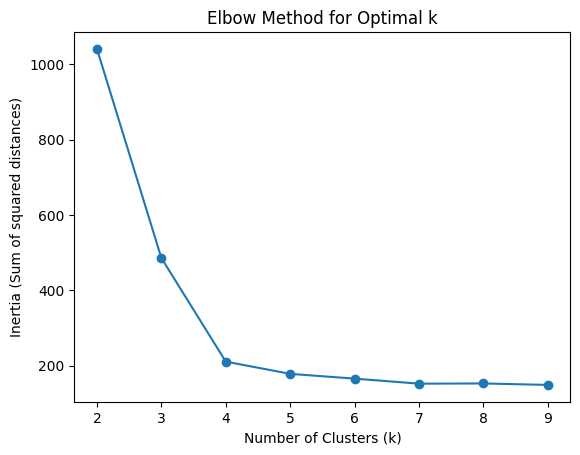

In [101]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

SILHOUETTE METHOD - higher number is for 4

In [102]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette score={score:.3f}")

k=2, silhouette score=0.455


k=3, silhouette score=0.574
k=4, silhouette score=0.663
k=5, silhouette score=0.595
k=6, silhouette score=0.581
k=7, silhouette score=0.465
k=8, silhouette score=0.360
k=9, silhouette score=0.221


K MEANS

In [103]:
from sklearn.cluster import KMeans

best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
df_totals["cluster"] = kmeans.fit_predict(X_scaled)

In [104]:
print(X_scaled.columns)

Index(['AUDIT_total_z', 'DAST_total_z', 'IAT_total_z', 'PGSI_total_z',
       'PCL5_total_z', 'MSPSS_total_z', 'SWLS_total_z', 'WHO5_total_z'],
      dtype='object')


making clusters

In [105]:
for col in X_scaled.columns:
    df_totals[col] = X_scaled[col]

cluster_summary = df_totals.groupby("cluster")[X_scaled.columns].mean().round(2)
print(cluster_summary)

         AUDIT_total_z  DAST_total_z  IAT_total_z  PGSI_total_z  PCL5_total_z  \
cluster                                                                         
0                -0.76          1.49         0.45         -0.89          1.69   
1                -0.80         -0.58         1.31         -0.06         -0.55   
2                 1.49         -1.07        -0.45          1.45         -0.55   
3                -0.00          0.23        -1.28         -0.57         -0.54   

         MSPSS_total_z  SWLS_total_z  WHO5_total_z  
cluster                                             
0                -1.45         -0.85         -0.85  
1                 0.84          0.42          0.37  
2                -0.25         -0.84         -0.87  
3                 0.84          1.29          1.36  


In [106]:
df_totals.to_csv("clustered_dataset_k4.csv", index=False)
print("Clusters saved to clustered_dataset_k4.csv")

Clusters saved to clustered_dataset_k4.csv
